In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.0.0


In [1]:
import sys 
# sys.path.clear()
sys.path.insert(0, 'D:\\Anaconda\\envs\\tensorflow_cpu\\python36.zip')
sys.path.insert(0, 'D:\\Anaconda\\envs\\tensorflow_cpu\\DLLs')
sys.path.insert(0, 'D:\\Anaconda\\envs\\tensorflow_cpu\\lib')
sys.path.insert(0, 'D:\\Anaconda\\envs\\tensorflow_cpu')
sys.path.insert(0, 'D:\\Anaconda\\envs\\tensorflow_cpu\\lib\\site-packages')
sys.path.insert(0, '')

In [2]:
import sys
sys.path

['/Users/litos/opt/anaconda3/envs/tensorflow_cpu/lib/python36.zip',
 '/Users/litos/opt/anaconda3/envs/tensorflow_cpu/lib/python3.6',
 '/Users/litos/opt/anaconda3/envs/tensorflow_cpu/lib/python3.6/lib-dynload',
 '',
 '/Users/litos/opt/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages',
 '/Users/litos/opt/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/IPython/extensions',
 '/Users/litos/.ipython']

sys.path = ['', '/Users/litos/opt/anaconda3/envs/tensorflow_cpu/lib/python36.zip', '/Users/litos/opt/anaconda3/envs/tensorflow_cpu/lib/python3.6', '/Users/litos/opt/anaconda3/envs/tensorflow_cpu/lib/python3.6/lib-dynload', '/Users/litos/opt/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages']

In [3]:
from gurobipy import *

In [67]:
from scipy.sparse import csr_matrix, load_npz, save_npz
from tqdm import tqdm
from sklearn.preprocessing import normalize
from collections import *
import datetime
import json
import pandas as pd
import time
# import yaml
import scipy.sparse as sparse
from ast import literal_eval

import numpy as np
import matplotlib.pyplot as plt
import random

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge
from sklearn.utils.extmath import randomized_svd

from scipy.optimize import minimize

# Load Data

In [5]:
# Load Original Data
df_train = pd.read_csv('../../data/yelp/Train.csv',encoding='latin-1')
# df_valid = pd.read_csv('../../data/yelp/Valid.csv',encoding='latin-1')
# df_test = pd.read_csv('../../data/yelp/Test.csv',encoding='latin-1')

In [6]:
keyphrases = pd.read_csv('../../data/yelp/KeyPhrases.csv')['Phrases'].tolist()
keyphrase_popularity = np.loadtxt('../data/yelp/'+'keyphrase_popularity.txt', dtype=int)

# Load U-I Data 
rtrain = load_npz("../../data/yelp/Rtrain.npz")
rvalid = load_npz("../../data/yelp/Rvalid.npz")
rtest = load_npz("../../data/yelp/Rtest.npz")

# Load user/item keyphrase data
U_K = load_npz("../../data/yelp/U_K.npz")
I_K = load_npz("../../data/yelp/I_K.npz")

# Models

In [7]:
# Models
from sklearn.metrics.pairwise import cosine_similarity
def train(matrix_train):
    similarity = cosine_similarity(X=matrix_train, Y=None, dense_output=True)
    return similarity

def get_I_K(df, row_name = 'ItemIndex', shape = (3668,75)):
    rows = []
    cols = []
    vals = []
    for i in tqdm(range(df.shape[0])):
        key_vector = literal_eval(df['keyVector'][i])
        rows.extend([df[row_name][i]]*len(key_vector)) ## Item index
        cols.extend(key_vector) ## Keyword Index
        vals.extend(np.array([1]*len(key_vector)))
    return csr_matrix((vals, (rows, cols)), shape=shape)



def prediction(prediction_score, topK, matrix_Train):

    prediction = []

    for user_index in tqdm(range(matrix_Train.shape[0])):
        vector_u = prediction_score[user_index]
        vector_train = matrix_Train[user_index]
        if len(vector_train.nonzero()[0]) > 0:
            vector_predict = sub_routine(vector_u, vector_train, topK=topK)
        else:
            vector_predict = np.zeros(topK, dtype=np.float32)

        prediction.append(vector_predict)

    return np.vstack(prediction)


def sub_routine(vector_u, vector_train, topK=500):

    train_index = vector_train.nonzero()[1]

    vector_u = vector_u

    candidate_index = np.argpartition(-vector_u, topK+len(train_index))[:topK+len(train_index)]
    vector_u = candidate_index[vector_u[candidate_index].argsort()[::-1]]
    vector_u = np.delete(vector_u, np.isin(vector_u, train_index).nonzero()[0])

    return vector_u[:topK]


In [8]:
def predict(matrix_train, k, similarity, item_similarity_en = False):
    """
    res = similarity * matrix_train    if item_similarity_en = False
    res = similarity * matrix_train.T  if item_similarity_en = True
    """
    prediction_scores = []
    
    if item_similarity_en:
        matrix_train = matrix_train.transpose()
        
    for user_index in tqdm(range(matrix_train.shape[0])):
        # Get user u's prediction scores to all users
        vector_u = similarity[user_index]

        # Get closest K neighbors excluding user u self
        similar_users = vector_u.argsort()[::-1][1:k+1]
        # Get neighbors similarity weights and ratings
        similar_users_weights = similarity[user_index][similar_users]
        similar_users_ratings = matrix_train[similar_users].toarray()

        prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]

        prediction_scores.append(np.sum(prediction_scores_u, axis=0))
    res = np.array(prediction_scores)
    
    if item_similarity_en:
        res = res.transpose()
    
    return res

def predict_vector(user_index, matrix_train, k, similarity):
    """
    res = similarity * matrix_train    if item_similarity_en = False
    res = similarity * matrix_train.T  if item_similarity_en = True
    get only user_index row
    """
    vector_u = similarity[user_index]
    
    # Get closest K neighbors excluding user u self
    similar_users = vector_u.argsort()[::-1][1:k+1]
    # Get neighbors similarity weights and ratings
    similar_users_weights = similarity[user_index][similar_users]
    similar_users_ratings = matrix_train[similar_users].toarray()
    prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]
    
    return np.sum(prediction_scores_u, axis=0)
    

In [9]:
# PLREC 
def inhour(elapsed):
    return time.strftime('%H:%M:%S', time.gmtime(elapsed))

def plrec(matrix_train, iteration=4, lamb=80, rank=200, seed=1):
    """
    Function used to achieve generalized projected lrec w/o item-attribute embedding
    :param matrix_train: user-item matrix with shape m*n
    :param iteration: number of power iterations in randomized svd
    :param lamb: parameter of penalty
    :param rank: latent dimension size
    :param seed: the seed of the pseudo random number generator to use when shuffling the data
    :return: prediction in sparse matrix
    """
    print ("Randomized SVD")
    start_time = time.time()
    P, sigma, Qt = randomized_svd(matrix_train,
                                  n_components=rank,
                                  n_iter=iteration,
                                  random_state=seed)

    RQ = matrix_train.dot(sparse.csc_matrix(Qt.T*np.sqrt(sigma)))

    print("Elapsed: {}".format(inhour(time.time() - start_time)))

    print ("Closed-Form Linear Optimization")
    start_time = time.time()
    pre_inv = RQ.T.dot(RQ) + lamb * sparse.identity(rank, dtype=np.float32)
    inverse = sparse.linalg.inv(pre_inv.tocsc())
    Y = inverse.dot(RQ.T).dot(matrix_train)
    print("Elapsed: {}".format(inhour(time.time() - start_time)))

    return np.array(RQ.todense()), np.array(Y.todense()), None

def predict_vector(rating_vector, train_vector, remove_train=True):
    dim = len(rating_vector)
    candidate_index = np.argpartition(-rating_vector, dim-1)[:dim]
    prediction_items = candidate_index[rating_vector[candidate_index].argsort()[::-1]]
    
    if remove_train:
        return np.delete(prediction_items, np.isin(prediction_items, train_vector.nonzero()[1]).nonzero()[0])
    else:
        return prediction_items

    
    
def predict_scores(matrix_U, matrix_V, bias=None,
                   penalize = False,
                   keyphrase_freq = I_K, 
                   critiqued_keyphrase = 0, 
                   matrix_Train = rtrain,
                   alpha = 0):
    prediction = matrix_U.dot(matrix_V.T)
    # Penalize
    if penalize == True:
        items_with_keyphrase = np.ravel(keyphrase_freq.T[critiqued_keyphrase].nonzero()[1])
        items_without_keyphrase = np.setdiff1d(np.arange(matrix_Train.shape[1]), items_with_keyphrase)
        prediction[items_without_keyphrase] = alpha # penalize
    
    return prediction


# Evaluation

In [10]:
# Evluation 
def recallk(vector_true_dense, hits, **unused):
    hits = len(hits.nonzero()[0])
    return float(hits)/len(vector_true_dense)

def precisionk(vector_predict, hits, **unused):
    hits = len(hits.nonzero()[0])
    return float(hits)/len(vector_predict)


def average_precisionk(vector_predict, hits, **unused):
    precisions = np.cumsum(hits, dtype=np.float32)/range(1, len(vector_predict)+1)
    return np.mean(precisions)


def r_precision(vector_true_dense, vector_predict, **unused):
    vector_predict_short = vector_predict[:len(vector_true_dense)]
    hits = len(np.isin(vector_predict_short, vector_true_dense).nonzero()[0])
    return float(hits)/len(vector_true_dense)


def _dcg_support(size):
    arr = np.arange(1, size+1)+1
    return 1./np.log2(arr)


def ndcg(vector_true_dense, vector_predict, hits):
    idcg = np.sum(_dcg_support(len(vector_true_dense)))
    dcg_base = _dcg_support(len(vector_predict))
    dcg_base[np.logical_not(hits)] = 0
    dcg = np.sum(dcg_base)
    return dcg/idcg


def click(hits, **unused):
    first_hit = next((i for i, x in enumerate(hits) if x), None)
    if first_hit is None:
        return 5
    else:
        return first_hit/10


def evaluate(matrix_Predict, matrix_Test, metric_names =['R-Precision', 'NDCG', 'Precision', 'Recall', 'MAP'], atK = [5, 10, 15, 20, 50], analytical=False):
    """
    :param matrix_U: Latent representations of users, for LRecs it is RQ, for ALSs it is U
    :param matrix_V: Latent representations of items, for LRecs it is Q, for ALSs it is V
    :param matrix_Train: Rating matrix for training, features.
    :param matrix_Test: Rating matrix for evaluation, true labels.
    :param k: Top K retrieval
    :param metric_names: Evaluation metrics
    :return:
    """
    global_metrics = {
        "R-Precision": r_precision,
        "NDCG": ndcg,
        "Clicks": click
    }

    local_metrics = {
        "Precision": precisionk,
        "Recall": recallk,
        "MAP": average_precisionk
    }

    output = dict()

    num_users = matrix_Predict.shape[0]

    for k in atK:

        local_metric_names = list(set(metric_names).intersection(local_metrics.keys()))
        results = {name: [] for name in local_metric_names}
        topK_Predict = matrix_Predict[:, :k]

        for user_index in tqdm(range(topK_Predict.shape[0])):
            vector_predict = topK_Predict[user_index]
            if len(vector_predict.nonzero()[0]) > 0:
                vector_true = matrix_Test[user_index]
                vector_true_dense = vector_true.nonzero()[1]
                hits = np.isin(vector_predict, vector_true_dense)

                if vector_true_dense.size > 0:
                    for name in local_metric_names:
                        results[name].append(local_metrics[name](vector_true_dense=vector_true_dense,
                                                                 vector_predict=vector_predict,
                                                                 hits=hits))

        results_summary = dict()
        if analytical:
            for name in local_metric_names:
                results_summary['{0}@{1}'.format(name, k)] = results[name]
        else:
            for name in local_metric_names:
                results_summary['{0}@{1}'.format(name, k)] = (np.average(results[name]),
                                                              1.96*np.std(results[name])/np.sqrt(num_users))
        output.update(results_summary)

    global_metric_names = list(set(metric_names).intersection(global_metrics.keys()))
    results = {name: [] for name in global_metric_names}

    topK_Predict = matrix_Predict[:]

    for user_index in tqdm(range(topK_Predict.shape[0])):
        vector_predict = topK_Predict[user_index]

        if len(vector_predict.nonzero()[0]) > 0:
            vector_true = matrix_Test[user_index]
            vector_true_dense = vector_true.nonzero()[1]
            hits = np.isin(vector_predict, vector_true_dense)

            # if user_index == 1:
            #     import ipdb;
            #     ipdb.set_trace()

            if vector_true_dense.size > 0:
                for name in global_metric_names:
                    results[name].append(global_metrics[name](vector_true_dense=vector_true_dense,
                                                              vector_predict=vector_predict,
                                                              hits=hits))

    results_summary = dict()
    if analytical:
        for name in global_metric_names:
            results_summary[name] = results[name]
    else:
        for name in global_metric_names:
            results_summary[name] = (np.average(results[name]), 1.96*np.std(results[name])/np.sqrt(num_users))
    output.update(results_summary)

    return output



## Single Step Critiquing Pipline

### Initial Prediction

In [11]:
# KNN initial Prediction
def get_initial_prediction(user,X = normalize(U_K.todense()), y = normalize(train(rtrain)),
                            matrix_Train = rtrain, k = 100):
    """
    Get the initial knn predictions before critiquing pipelines
    get the linear regression model for critiquing embedding (W_2)
    get the initial user similarity matrix 
    k here is the parameter for KNN
    """
    clf = Ridge(alpha=0.1).fit(X, y)
    similarity = normalize(train(matrix_Train))
    user_item_prediction_score = predict_vector(user, matrix_Train, k, similarity)
    return user_item_prediction_score, clf


In [12]:
# PLREC initial Prediction
def predict_scores(matrix_U, matrix_V, bias=None,
                   penalize = False,
                   keyphrase_freq = I_K, 
                   critiqued_keyphrase = 0, 
                   matrix_Train = rtrain,
                   alpha = 0):
    
    prediction = matrix_U.dot(matrix_V.T)
    # Penalize
    if penalize == True:
        items_with_keyphrase = np.ravel(keyphrase_freq.T[critiqued_keyphrase].nonzero()[1])
        items_without_keyphrase = np.setdiff1d(np.arange(matrix_Train.shape[1]), items_with_keyphrase)
        prediction[items_without_keyphrase] = alpha # penalize
    
    return prediction


### Forward predict

Predict a single row (for single user)

In [13]:
# KNN

def predict_vector(user_index, matrix_train, k, similarity):
    """
    res = similarity * matrix_train    if item_similarity_en = False
    res = similarity * matrix_train.T  if item_similarity_en = True
    get only user_index row
    """
    vector_u = similarity[user_index]
    
    # Get closest K neighbors excluding user u self
    similar_users = vector_u.argsort()[::-1][1:k+1]
    # Get neighbors similarity weights and ratings
    similar_users_weights = similarity[user_index][similar_users]
    similar_users_ratings = matrix_train[similar_users].toarray()
    prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]
    
    return np.sum(prediction_scores_u, axis=0)
    

def predict_vector(user_index, matrix_train, k, similarity, with_keyphrase = False, 
                   keyphrase_freq = None, critiqued_keyphrase = None, alpha = 0):
    """
    get only user_index row
    if with_keyphrase = True, then penalize items without critiqued_keyphrase to alpha (default = 0)
    """
    vector_u = similarity[user_index]
    
    # Get closest K neighbors excluding user u self
    similar_users = vector_u.argsort()[::-1][1:k+1]
    # Get neighbors similarity weights and ratings
    similar_users_weights = similarity[user_index][similar_users]
    similar_users_ratings = matrix_train[similar_users].toarray()
    
    prediction_scores_u = similar_users_ratings * similar_users_weights[:, np.newaxis]
    
    if with_keyphrase == False:
        return np.sum(prediction_scores_u, axis=0)
    
    # Only Predict items with critiqued_keyphrase 
    else:
        prediction_scores = np.sum(prediction_scores_u, axis=0)
#         print (prediction_scores)
        #penalize items without critiqued keyphrase
        items_with_keyphrase = np.ravel(keyphrase_freq.T[critiqued_keyphrase].nonzero()[1])
#         print (items_with_keyphrase)
        #Return the unique values in ar1 that are not in ar2.
        items_without_keyphrase = np.setdiff1d(np.arange(matrix_train.shape[1]), items_with_keyphrase)
        prediction_scores[items_without_keyphrase] = alpha # penalize
        return prediction_scores
#         print (prediction_scores)
#         return prediction_scores/sum(prediction_scores)


In [14]:
# PLREC
def predict_vector(rating_vector, train_vector, remove_train=True):
    dim = len(rating_vector)
    candidate_index = np.argpartition(-rating_vector, dim-1)[:dim]
    prediction_items = candidate_index[rating_vector[candidate_index].argsort()[::-1]]
    
    if remove_train:
        return np.delete(prediction_items, np.isin(prediction_items, train_vector.nonzero()[1]).nonzero()[0])
    else:
        return prediction_items


### Keyphrase Selection

In [15]:
def get_valid_keyphrases(keyphrase_freq,top_recommendations,item = None,threshold=50,mutiple_keyphrases_en = False, top_items = None):
    """
    Wrapper function to get either top 1 or top n keyphrases
    """
    if mutiple_keyphrases_en:
        top_keyphrases = []
        for item in top_items:
            top_keyphrases.extend(get_valid_keyphrases_for_one_item(keyphrase_freq,top_recommendations,item,threshold=threshold))
        return np.ravel(list(set(top_keyphrases))) # remove duplicate and reformat to np array
    else:
        return get_valid_keyphrases_for_one_item(keyphrase_freq,top_recommendations,item,threshold=threshold)

def get_valid_keyphrases_for_one_item(keyphrase_freq,top_recommendations, item,threshold=50):
    """
    Get keyphrases of item that make sense
    E.g. if the item has fewer than threshold=50 keyphrases, get all of them
    otherwise get top 50 keyphrases
    """
    keyphrase_length = len(keyphrase_freq[item].nonzero()[1])
    if keyphrase_length<threshold:
        return keyphrase_freq[item].nonzero()[1]
    else:
        keyphrases = np.ravel(keyphrase_freq[top_recommendations[0]].todense())
        top_keyphrases = np.argsort(keyphrases)[::-1][:threshold]
        return top_keyphrases
    
# For keyphrase selecting method # 3 "diff" 
def get_item_keyphrase_freq(keyphrase_freq,item):
    """
    Get item's keyphrase frequency 
    """
    count = keyphrase_freq[item].todense()
    return count/np.sum(count)

def get_keyphrase_popularity(df,keyphrases):
    """
    Get keyphrase popularity (count) from dataframe
    """
    keyphrase_popularity = np.zeros(len(keyphrases)) #initialize
    for i in range(len(df)):
        keyphrase_vector = literal_eval(df['keyVector'][i])
        keyphrase_popularity[keyphrase_vector] += 1 # count
    return keyphrase_popularity

### Critiquing Methods

In [16]:
# One hot encoding of critiquing
def get_critiqued_UK(user_keyphrase_frequency,user_index,critiqued_keyphrase):
    """
    user_keyphrase_frequency is the U_K matrix (csr sparse matrix)
    return the one-hot encoding of the critique
    """
    U_K_cp = user_keyphrase_frequency.copy()
    U_K_cp[user_index] = 0
    U_K_cp[user_index,critiqued_keyphrase] = 1
    return U_K_cp

def project_one_hot_encoding(reg, user_keyphrase_frequency,user_index = 0,critiqued_keyphrase = 0, normalize_en = True):
    """
    Return the projection on user_sim space from one-hot encoding of critiqued keyphrase
    The res[user_index] should be target embedding row
    """
    critiqued_matrix = get_critiqued_UK(user_keyphrase_frequency, user_index, critiqued_keyphrase)
    res = reg.predict(critiqued_matrix)
    if normalize_en:
        res = normalize((res))
    return res

In [17]:
# Upper bound method 
def get_all_affected_items(wanted_keyphrases,keyphrase_freq):
    res = []
    for keyphrase in wanted_keyphrases:
        items = np.ravel(keyphrase_freq.T[keyphrase].nonzero()[1])
        res.extend(items)
    return np.array(list(set(res)))
    
def select_only_wanted_keyphrase(top_recommendations, wanted_keyphrases, keyphrase_freq, matrix_Train = rtrain):
    all_items_with_keyphrases = get_all_affected_items(wanted_keyphrases,keyphrase_freq)
    affected_items = np.setdiff1d(np.arange(matrix_Train.shape[1]), all_items_with_keyphrases) # Get all other keyphrases
    top_recommendations[~np.in1d(top_recommendations, affected_items)]
    return top_recommendations

def pruning(prediction_score, 
           wanted_keyphrases_random, 
           top_recommendations, 
           keyphrase_freq, 
           matrix_Train = rtrain,
           alpha = 0):
    items_with_keyphrase = get_all_affected_items(wanted_keyphrases_random, keyphrase_freq)
    #Return the unique values in ar1 that are not in ar2.
    items_without_keyphrase = np.setdiff1d(np.arange(matrix_Train.shape[1]), items_with_keyphrase)
#     print (items_without_keyphrase)
    print (sum(prediction_score[items_without_keyphrase]))
    score = np.copy(prediction_score)
    score[items_without_keyphrase] = alpha # penalize
    return score

### Utilities

In [18]:
# Utility function for getting restaurant info from ItemIndex
def get_business_df(path = "../../data/yelp/business.json" ):
    with open(path,encoding="utf8") as json_file:
        data = json_file.readlines()
        data = list(map(json.loads, data))
    df = pd.DataFrame(data)
    
    return df

def get_restaurant_info(business_df, business_id, name = True, review_count = True, stars = True ):
    output_list = {}
    row_idx = int(business_df.index[business_df['business_id'] == business_id].tolist()[0])
    if name == True:
        output_list['name'] = business_df['name'][row_idx].encode('utf-8').strip()
    if review_count == True:
        output_list['review_count'] = business_df['review_count'][row_idx]
    if stars == True:
        output_list['stars'] = business_df['stars'][row_idx] 
    return output_list

# def get_businessid_from_Itemindex(ItemIndex_list, itemindex):
#     return ItemIndex_list['business_id'].tolist()[itemindex]

def get_restaurant_name(df_train, business_df, ItemIndex):
    rows = np.where(df_train['ItemIndex'] == ItemIndex)
    if len(rows)!= 0:
        business_id = df_train.loc[rows[0][0]]['business_id']
        item_info = get_restaurant_info(business_df, business_id)
        return item_info['name']
    return "NOT_FOUND"

### Experiment Function

In [19]:
business_df = get_business_df()

In [20]:
Y, RQt, Bias = plrec(rtrain,
                    iteration = 10,
                    lamb = 200,
                    rank = 200)
RQ = RQt.T
reg = LinearRegression().fit(normalize(U_K), Y)

Randomized SVD
Elapsed: 00:00:00
Closed-Form Linear Optimization
Elapsed: 00:00:00


In [21]:
# Set up dataframe 

# post_ranki is post rank with different lambda ratio for combining pre-post User similarity matrix 

columns = ['user_id', 'target_item', 'item_name', 'iter', 'pre_rank', 
           'top_prediction_item_name',
           'post_rank_random_all',
           'post_rank_random_upper',
           'random_scores',
           'post_rank_pop_all',
           'post_rank_pop_upper',
           'pop_scores',
           'post_rank_diff_all',
           'post_rank_diff_upper',
           'diff_scores',
           'critiqued_keyphrase_random',
           'keyphrase_name_random',
           'critiqued_keyphrase_pop',
           'keyphrase_name_pop',
           'critiqued_keyphrase_diff',
           'keyphrase_name_diff',
           'num_existing_keyphrases',
           'pure_pruning_rank'] 
df = pd.DataFrame(columns=columns)
row = {}

In [150]:
def single_step_critiquing_plrec(user = 2, 
                           keyphrase_length_threshold = 150, 
                           max_iteration_threshold = 5,
                           k = 50,
                           df = df,
                           row = row,
                           business_df = business_df,
                           keyphrases = keyphrases,
                           keyphrase_popularity = keyphrase_popularity, 
                           keyphrase_selection_method = 'random',
                           recommend_type = 'all',
                           lams = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
                           reg = reg, Y = Y, RQt = RQt, Bias = Bias,
                           top_k_rec = 20, affected_weight = 1, unaffected_weight = -1,
                                 w1 = 1, w2 = 1
                          ):
    """
    k: HR@k 
    keyphrase_length_threshold: limit the number of keyphrases in top recommended item
    keyphrase_selection_method: 'random': randomly select keyphrase from wanted_keyphrases
                                'pop': always select the most popular keyphrase in wanted_keyphrases
                                'diff': select the keyphrase with largest frequency difference between top recommended 
                                        item and target item.
    recommend_type: 'all': recommend all items
                    'upper' (only_with_critiqued_keyphrase): recommend items with only critiqued_keyphrase
    lam: modified_matrix = lam*origianl_matrix + (1-lam)*critiquing_embedding 
    """
    
    row['user_id'] = user
    print ('User ID ', user)
    
    # Set up (move to header line later)
    matrix_Train = rtrain
    matrix_Test = rtest
    keyphrase_freq = I_K
    num_items = rtrain.shape[1]
    max_wanted_keyphrase = 10 # for keyphrase_selection_method == "diff"
    initial_user_similarity_embedding = normalize(train(matrix_Train))
    
    # Get wanted items 
    candidate_items = matrix_Test[user].nonzero()[1]
    train_items = matrix_Train[user].nonzero()[1]
    wanted_items = np.setdiff1d(candidate_items, train_items)
    print ('wanted_items length: ',len(wanted_items))
    
    # Get initial forward prediction 
    prediction_score = predict_scores(matrix_U=RQ,
                                      matrix_V=Y,
                                      bias=Bias).T[user]
    prediction_items = predict_vector(rating_vector=prediction_score,
                                                              train_vector=matrix_Train[user],
                                                              remove_train=True)
    # Get initial top recommended item(s)
    top_recommendations = np.argsort(prediction_score)[::-1]
    print ("Initial top recommendation index",top_recommendations[0])
    try:
        row['top_prediction_item_name'] = get_restaurant_name(df_train, business_df, top_recommendations[0])
    except: 
        row['top_prediction_item_name'] = 'CANNOT_FIND'
        print ('Cannot get restaurant name for ItemIndex: ', top_recommendations[0])
    
    
    # Get top recommended item's keyphrases
    top_item = top_recommendations[0] 
    top_recommend_keyphrases = get_valid_keyphrases(keyphrase_freq,
                                                    top_recommendations, 
                                                    item = top_item,
                                                    threshold=keyphrase_length_threshold,
                                                    mutiple_keyphrases_en = False, 
                                                    top_items = None)
    top_recommended_keyphrase_freq = get_item_keyphrase_freq(keyphrase_freq,item = top_item)
    
    
    #####################################
    # For each item, do the critiquing
    
    #limit the item to only 10
    num_target_item = 0 # initialize item count
    
    for item in wanted_items:    
        print ('target_item: ', item)
        row['target_item'] = item
        try:
            row['item_name'] = get_restaurant_name(df_train, business_df, item)
        except:
            row['item_name'] = 'CANNOT_FIND'
            print ('Cannot get restaurant name for ItemIndex: ', item)

        # Get pre-critiquing rank
        initial_rank = np.where(item == np.argsort(prediction_score)[::-1])[0][0]
        row['pre_rank'] = int(initial_rank)

        # Get the target item's existing keyphrases
        item_keyphrases = keyphrase_freq[item].nonzero()[1]
        
        # For diff 
        target_keyphrase_freq = get_item_keyphrase_freq(keyphrase_freq,item = item)
        diff_keyphrase_freq = target_keyphrase_freq - top_recommended_keyphrase_freq
        
        wanted_keyphrases_random = np.setdiff1d(item_keyphrases,top_recommend_keyphrases)
        wanted_keyphrases_pop = np.setdiff1d(item_keyphrases,top_recommend_keyphrases)
        wanted_keyphrases_diff = np.argsort(np.ravel(diff_keyphrase_freq))[::-1][:max_wanted_keyphrase]
        
        pruned_prediction_score = pruning(prediction_score, 
                                           wanted_keyphrases_random, 
                                           top_recommendations, 
                                           keyphrase_freq, 
                                           matrix_Train = rtrain)
        pure_pruning_rank = np.where(item == np.argsort(pruned_prediction_score)[::-1])[0][0]
        if pure_pruning_rank>initial_rank:
            pure_pruning_rank = initial_rank
        row['pure_pruning_rank'] = int(pure_pruning_rank)    
        
        affected_items = np.array([])
        modified_matrix = initial_user_similarity_embedding # initialize user similarity embedding
        
        #############################################
        # Critiquing iteration
        for iteration in range(max_iteration_threshold):
            print ('cur_iter ', iteration)
            row['iter'] = iteration

            if len(wanted_keyphrases_random) == 0 or len(wanted_keyphrases_diff) == 0: 
                print ('no more keyphrase available')
                break
            critiqued_keyphrase_random = np.random.choice(wanted_keyphrases_random, size=1, replace=False)[0]
            critiqued_keyphrase_pop = wanted_keyphrases_pop[np.argmin(keyphrase_popularity[wanted_keyphrases_pop])] # Select the least popular
            critiqued_keyphrase_diff = wanted_keyphrases_diff[0]
            
            row['critiqued_keyphrase_random'] = critiqued_keyphrase_random
            row['keyphrase_name_random'] = keyphrases[critiqued_keyphrase_random]
            row['critiqued_keyphrase_pop'] = critiqued_keyphrase_pop
            row['keyphrase_name_pop'] = keyphrases[critiqued_keyphrase_pop]
            row['critiqued_keyphrase_diff'] = critiqued_keyphrase_diff
            row['keyphrase_name_diff'] = keyphrases[critiqued_keyphrase_diff]
            
            # Do not critique this keyphrase next time
            wanted_keyphrases_random = np.delete(wanted_keyphrases_random, np.where(critiqued_keyphrase_random == wanted_keyphrases_random))
            wanted_keyphrases_pop = np.delete(wanted_keyphrases_pop, np.where(critiqued_keyphrase_pop == wanted_keyphrases_pop))
            wanted_keyphrases_diff = np.delete(wanted_keyphrases_diff, np.where(critiqued_keyphrase_diff == wanted_keyphrases_diff))
            
            # Critiquing Embedding

            # One hot encoding
            critiqued_matrix_onehot = get_critiqued_UK(U_K,user,critiqued_keyphrase_random)
            critiqued_matrix = reg.predict(critiqued_matrix_onehot)
            critiqued_matrix_random =critiqued_matrix

            critiqued_matrix_onehot = get_critiqued_UK(U_K,user,critiqued_keyphrase_pop)
            critiqued_matrix = reg.predict(critiqued_matrix_onehot)
            critiqued_matrix_pop = critiqued_matrix

            critiqued_matrix_onehot = get_critiqued_UK(U_K,user,critiqued_keyphrase_diff)
            critiqued_matrix = reg.predict(critiqued_matrix_onehot)
            critiqued_matrix_diff = critiqued_matrix


            # Warning!!! The following is used only for testing single step critiquing, 
            # for full average critiquing, use the above commented line 
            post_ranks_random_all = []
            post_ranks_random_upper = []
            random_scores = []
            random_ratings = []
            post_ranks_pop_all = []
            post_ranks_pop_upper = []
            pop_scores = []
            pop_ratings = []
            post_ranks_diff_all = []
            post_ranks_diff_upper = []
            diff_scores = []
            diff_ratings = []
            
            num_items = matrix_Train.shape[1]
            affected_items_random = keyphrase_freq[:,critiqued_keyphrase_random].nonzero()[0]
            affected_items_pop = keyphrase_freq[:,critiqued_keyphrase_pop].nonzero()[0]
            affected_items_diff = keyphrase_freq[:,critiqued_keyphrase_diff].nonzero()[0]
            
            unaffected_items_random = np.setdiff1d(range(num_items), affected_items_random)
            unaffected_items_pop = np.setdiff1d(range(num_items), affected_items_pop)
            unaffected_items_diff = np.setdiff1d(range(num_items), affected_items_diff)
            
            for lam in lams:
                modified_matrix_random = (1-lam)*Y + lam*critiqued_matrix_random 
                modified_matrix_pop = (1-lam)*Y + lam*critiqued_matrix_pop 
                modified_matrix_diff = (1-lam)*Y + lam*critiqued_matrix_diff 
                
                # Random
                prediction_scores_u = predict_scores(matrix_U=modified_matrix_random[user], 
                                     matrix_V=RQ,
                                     )
                prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                                  train_vector=matrix_Train[user],
                                                  remove_train=False)
                
                item_rank = np.where(prediction_items == item)[0][0]
                post_ranks_random_all.append(item_rank)
                
                # Random scores
                affected_hit = sum(np.in1d(prediction_items[:top_k_rec],affected_items_random))
                unaffected_hit = sum(np.in1d(prediction_items[:top_k_rec],unaffected_items_random))
                score = affected_weight*affected_hit + unaffected_weight*unaffected_hit
                random_scores.append(score)
                
                # Random Rating
                latent_diff = modified_matrix_random - Y #post-pre
                rating_diff = predict_scores(matrix_U=latent_diff[user], 
                                     matrix_V=RQ,
                                     )
                affected_items_mask = np.in1d(prediction_items, affected_items_random)
                affected_items_index_rank = np.where(affected_items_mask == True)
                unaffected_items_index_rank = np.where(affected_items_mask == False)
                
                rating_diff_sum_unaffected = np.sum(np.abs(rating_diff), where = np.in1d(range(num_items),np.intersect1d(unaffected_items_random, prediction_items[unaffected_items_index_rank[0][:100]])))
                rating_diff_sum_affected = np.sum(rating_diff, where = np.in1d(range(num_items), np.intersect1d(affected_items_random, prediction_items[affected_items_index_rank[0][:100]])))
                rating_score = w1*rating_diff_sum_unaffected - w2*rating_diff_sum_affected
#                 print (rating_score)
                random_ratings.append(rating_score)
    
                # Random upper 
                prediction_scores_u = predict_scores(matrix_U=modified_matrix_random[user], 
                                                     matrix_V=RQ, 
                                                     bias=None,
                                                   penalize = True,
                                                   keyphrase_freq = keyphrase_freq, 
                                                   critiqued_keyphrase = critiqued_keyphrase_random, 
                                                   matrix_Train = matrix_Train,
                                                   alpha = 0)
                prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                                  train_vector=matrix_Train[user],
                                                  remove_train=False)
                item_rank = np.where(prediction_items == item)[0][0]
                post_ranks_random_upper.append(item_rank)
                
                # Pop
                prediction_scores_u = predict_scores(matrix_U=modified_matrix_pop[user], 
                                     matrix_V=RQ,
                                     )
                prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                                  train_vector=matrix_Train[user],
                                                  remove_train=False)
                
                item_rank = np.where(prediction_items == item)[0][0]
                post_ranks_pop_all.append(item_rank)
                
                
                # pop scores
                affected_hit = sum(np.in1d(prediction_items[:top_k_rec],affected_items_pop))
                unaffected_hit = sum(np.in1d(prediction_items[:top_k_rec],unaffected_items_pop))
                score = affected_weight*affected_hit + unaffected_weight*unaffected_hit
                pop_scores.append(score)
            
                # Pop Rating
                latent_diff = modified_matrix_pop - Y #post-pre
                rating_diff = predict_scores(matrix_U=latent_diff[user], 
                                     matrix_V=RQ,
                                     )
                affected_items_mask = np.in1d(prediction_items, affected_items_pop)
                affected_items_index_rank = np.where(affected_items_mask == True)
                unaffected_items_index_rank = np.where(affected_items_mask == False)
                
                rating_diff_sum_unaffected = np.sum(np.abs(rating_diff), where = np.in1d(range(num_items),np.intersect1d(unaffected_items_pop, prediction_items[unaffected_items_index_rank[0][:100]])))
                rating_diff_sum_affected = np.sum(rating_diff, where = np.in1d(range(num_items), np.intersect1d(affected_items_pop, prediction_items[affected_items_index_rank[0][:100]])))
                rating_score = w1*rating_diff_sum_unaffected - w2*rating_diff_sum_=affected
                pop_ratings.append(rating_score)
                
                # Pop upper 
                
                prediction_scores_u = predict_scores(matrix_U=modified_matrix_pop[user], 
                                                     matrix_V=RQ, 
                                                     bias=None,
                                                   penalize = True,
                                                   keyphrase_freq = keyphrase_freq, 
                                                   critiqued_keyphrase = critiqued_keyphrase_pop, 
                                                   matrix_Train = matrix_Train,
                                                   alpha = 0)
                prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                                  train_vector=matrix_Train[user],
                                                  remove_train=False)
                item_rank = np.where(prediction_items == item)[0][0]
                post_ranks_pop_upper.append(item_rank)
                
                # Diff
                prediction_scores_u = predict_scores(matrix_U=modified_matrix_diff[user], 
                                     matrix_V=RQ,
                                     )
                prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                                  train_vector=matrix_Train[user],
                                                  remove_train=False)
                
                item_rank = np.where(prediction_items == item)[0][0]
                post_ranks_diff_all.append(item_rank)
                
                # Diff scores
                affected_hit = sum(np.in1d(prediction_items[:top_k_rec],affected_items_diff))
                unaffected_hit = sum(np.in1d(prediction_items[:top_k_rec],unaffected_items_diff))
                score = affected_weight*affected_hit + unaffected_weight*unaffected_hit
                diff_scores.append(score)
                
                # Diff Rating
                latent_diff = modified_matrix_diff - Y #post-pre
                rating_diff = predict_scores(matrix_U=latent_diff[user], 
                                     matrix_V=RQ,
                                     )
                affected_items_mask = np.in1d(prediction_items, affected_items_diff)
                affected_items_index_rank = np.where(affected_items_mask == True)
                unaffected_items_index_rank = np.where(affected_items_mask == False)
                
                rating_diff_sum_unaffected = np.sum(np.abs(rating_diff), where = np.in1d(range(num_items),np.intersect1d(unaffected_items_diff, prediction_items[unaffected_items_index_rank[0][:100]])))
                rating_diff_sum_affected = np.sum(rating_diff, where = np.in1d(range(num_items), np.intersect1d(affected_items_diff, prediction_items[affected_items_index_rank[0][:100]])))
                rating_score = w1*rating_diff_sum_unaffected - w2*rating_diff_sum_affected
                diff_ratings.append(rating_score)
                # Diff upper 
                prediction_scores_u = predict_scores(matrix_U=modified_matrix_diff[user], 
                                                     matrix_V=RQ, 
                                                     bias=None,
                                                   penalize = True,
                                                   keyphrase_freq = keyphrase_freq, 
                                                   critiqued_keyphrase = critiqued_keyphrase_diff, 
                                                   matrix_Train = matrix_Train,
                                                   alpha = 0)
                prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                                  train_vector=matrix_Train[user],
                                                  remove_train=False)
                item_rank = np.where(prediction_items == item)[0][0]
                post_ranks_diff_upper.append(item_rank)
            
            ######################################################
            # optimal predicted lambda from ranking obj 
            random_ranking_opti_predicted = lams[np.argmax(random_scores)]
            pop_ranking_opti_predicted = lams[np.argmax(pop_scores)]
            diff_ranking_opti_predicted = lams[np.argmax(diff_scores)]
            
            # optimal predicted lambda from rating obj 
            random_rating_opti_predicted = lams[np.argmin(random_ratings)]
            pop_rating_opti_predicted = lams[np.argmin(pop_ratings)]
            diff_rating_opti_predicted = lams[np.argmin(diff_ratings)]
            
            ####################################################
            # Get optimal post_ranking predicted
            modified_matrix_random_opti_predicted = (1-random_ranking_opti_predicted)*Y + random_ranking_opti_predicted*critiqued_matrix_random 
            modified_matrix_pop_opti_predicted = (1-random_ranking_opti_predicted)*Y + random_ranking_opti_predicted*critiqued_matrix_pop 
            modified_matrix_diff_opti_predicted = (1-random_ranking_opti_predicted)*Y + random_ranking_opti_predicted*critiqued_matrix_diff 
            # Random
            prediction_scores_u = predict_scores(matrix_U=modified_matrix_random_opti_predicted[user], 
                                     matrix_V=RQ,
                                     )
            prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                              train_vector=matrix_Train[user],
                                              remove_train=False)

            item_rank = np.where(prediction_items == item)[0][0]
            row['random_opti_ranking'] = item_rank
            
            modified_matrix_random_opti_predicted = (1-random_rating_opti_predicted)*Y + random_rating_opti_predicted*critiqued_matrix_random 
            prediction_scores_u = predict_scores(matrix_U=modified_matrix_random_opti_predicted[user], 
                                     matrix_V=RQ,
                                     )
            prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                              train_vector=matrix_Train[user],
                                              remove_train=False)

            item_rank = np.where(prediction_items == item)[0][0]
            row['random_opti_rating'] = item_rank
            
            # Pop
            prediction_scores_u = predict_scores(matrix_U=modified_matrix_pop_opti_predicted[user], 
                                     matrix_V=RQ,
                                     )
            prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                              train_vector=matrix_Train[user],
                                              remove_train=False)

            item_rank = np.where(prediction_items == item)[0][0]
            row['pop_opti_ranking'] = item_rank
            
            modified_matrix_pop_opti_predicted = (1-pop_rating_opti_predicted)*Y + pop_rating_opti_predicted*critiqued_matrix_pop 
            prediction_scores_u = predict_scores(matrix_U=modified_matrix_pop_opti_predicted[user], 
                                     matrix_V=RQ,
                                     )
            prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                              train_vector=matrix_Train[user],
                                              remove_train=False)

            item_rank = np.where(prediction_items == item)[0][0]
            row['pop_opti_rating'] = item_rank
            
            # Diff
            prediction_scores_u = predict_scores(matrix_U=modified_matrix_diff_opti_predicted[user], 
                                     matrix_V=RQ,
                                     )
            prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                              train_vector=matrix_Train[user],
                                              remove_train=False)

            item_rank = np.where(prediction_items == item)[0][0]
            row['diff_opti_ranking'] = item_rank
            
            modified_matrix_diff_opti_predicted = (1-diff_rating_opti_predicted)*Y + diff_rating_opti_predicted*critiqued_matrix_diff 
            prediction_scores_u = predict_scores(matrix_U=modified_matrix_diff_opti_predicted[user], 
                                     matrix_V=RQ,
                                     )
            prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                              train_vector=matrix_Train[user],
                                              remove_train=False)

            item_rank = np.where(prediction_items == item)[0][0]
            row['diff_opti_rating'] = item_rank
            
            row['post_rank_random_all'] = post_ranks_random_all
            row['post_rank_random_upper'] = post_ranks_random_upper
            row['random_scores'] = random_scores
            row['random_ratings'] = random_ratings
            
            row['post_rank_pop_all'] = post_ranks_pop_all
            row['post_rank_pop_upper'] = post_ranks_pop_upper
            row['pop_scores'] = pop_scores
            row['pop_ratings'] = pop_ratings
            
            row['post_rank_diff_all'] = post_ranks_diff_all
            row['post_rank_diff_upper'] = post_ranks_diff_upper
            row['diff_scores'] = diff_scores
            row['diff_ratings'] = diff_ratings
            
            df = df.append(row, ignore_index=True)
            

        # break after got 10 target items 
        num_target_item += 1
        if num_target_item >10: # only want max 10 items per user
            break
            
    return df

SyntaxError: can't assign to operator (<ipython-input-150-d7db11c22102>, line 263)

In [149]:
np.argmax(literal_eval(df['random_scores'][0]))

9

In [100]:
single_step_with_avg_path = '../tables/critiquing/plrec_with_obj/'

In [ ]:
# Set up dataframe 

# post_ranki is post rank with different lambda ratio for combining pre-post User similarity matrix 

columns = ['user_id', 'target_item', 'item_name', 'iter', 'pre_rank', 
           'top_prediction_item_name',
           'post_rank_random_all',
           'post_rank_random_upper',
           'random_scores',
           'random_ratings',
           'random_opti_ranking',
           'random_opti_rating',
           'post_rank_pop_all',
           'post_rank_pop_upper',
           'pop_scores',
           'pop_ratings',
           'pop_opti_ranking',
           'pop_opti_rating',
           'post_rank_diff_all',
           'post_rank_diff_upper',
           'diff_scores',
           'diff_ratings',
           'diff_opti_ranking',
           'diff_opti_rating',
           'critiqued_keyphrase_random',
           'keyphrase_name_random',
           'critiqued_keyphrase_pop',
           'keyphrase_name_pop',
           'critiqued_keyphrase_diff',
           'keyphrase_name_diff',
           'num_existing_keyphrases',
           'pure_pruning_rank'] 
df = pd.DataFrame(columns=columns)
row = {}

#only_with_critiqued_keyphrase
for user in range(300,301):
    df = single_step_critiquing_plrec(user = user, 
                           keyphrase_length_threshold = 230, 
                           max_iteration_threshold = 10,
                           k = 50,
                           df = df,
                           row = row,
                           business_df = business_df,
                           keyphrases = keyphrases,
                           keyphrase_popularity = keyphrase_popularity,
                           keyphrase_selection_method = 'random',
                           recommend_type = 'all',
                           top_k_rec=100
                           )
df.to_csv(single_step_with_avg_path+"ranking_and_rating_test.csv")

User ID  300
wanted_items length:  14
Initial top recommendation index 5010
target_item:  101
41.54450767803064
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
no more keyphrase available
target_item:  886
17.15063242740507
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  968
16.475838166974427
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  1620
140.5959442619278
cur_iter  0
no more keyphrase available
target_item:  1898
10.686718769607978
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  2803
11.871685572277784
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  3822
131.28218291769008
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
no more keyphrase available
target_item:  4025
44.43994439533708
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
no more keyphrase available
target_item:  4906
28.516939810702752
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5041
11.519445263089438
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5
cur_iter  6
cur_iter  7
cur_iter  8
cur_iter  9
target_item:  5098
8.70336792814851
cur_iter  0


D:\Anaconda\envs\tensorflow_cpu\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


cur_iter  1
cur_iter  2
cur_iter  3
cur_iter  4
cur_iter  5


In [ ]:
df

In [27]:
df['post_rank_random_all'][0]

[4830, 4739, 4610, 4486, 4284, 3670, 3412, 3168, 2935, 2735, 2576]

# Forward

In [29]:
# KNN Forward 
similarity = normalize(train(rtrain))
user_item_prediction_score = predict(rtrain, 100, similarity, item_similarity_en= False)
user_item_predict = prediction(user_item_prediction_score, 50, rtrain)
user_item_res = evaluate(user_item_predict, rtest)

100%|██████████| 2343/2343 [00:00<00:00, 4548.68it/s]


In [30]:
# Evaluation result with k = 100
user_item_res

{'MAP@5': (0.06940666362391602, 0.0060646277121995185),
 'Recall@5': (0.026408137823500974, 0.002191309117794643),
 'Precision@5': (0.06462802373345505, 0.004754606217931856),
 'MAP@10': (0.06333952750429245, 0.00455145183026277),
 'Recall@10': (0.04269615369598775, 0.0027831077562657665),
 'Precision@10': (0.05330899132816066, 0.0032544740534870857),
 'MAP@15': (0.05872249612550844, 0.0038121823597348156),
 'Recall@15': (0.05562887733868642, 0.0031389991916236284),
 'Precision@15': (0.04698006998326487, 0.0025622684368576416),
 'MAP@20': (0.055196280875748356, 0.003345258771111864),
 'Recall@20': (0.0677664821917642, 0.003424484045821138),
 'Precision@20': (0.043336376083979916, 0.002222006808632301),
 'MAP@50': (0.04436838784245958, 0.0022020570312340938),
 'Recall@50': (0.12696642809611336, 0.0048241883971306436),
 'Precision@50': (0.032889091738931994, 0.0014317314500480152),
 'R-Precision': (0.048464138894968055, 0.0027869069242192506),
 'NDCG': (0.09071795198195, 0.00380397059001

In [ ]:
# PLREC Forward


In [ ]:
# PLREC 


In [ ]:
# Learn User-Keyphrase matrix to Latent Embedding
# Training 
X = normalize(U_K.todense())
y = normalize(train(rtrain))
clf = Ridge(alpha=0.1).fit(X, y) # Optimality at L2 regularization = 0.1
lr_similarity = clf.predict(np.array(X))

# Experiment

In [32]:
# keyphrase_popularity = get_keyphrase_popularity(df_train,keyphrases)

# Save and load
# np.savetxt('../data/yelp/'+'keyphrase_popularity.txt', keyphrase_popularity, fmt='%d')
keyphrase_popularity = np.loadtxt('../data/yelp/'+'keyphrase_popularity.txt', dtype=int)

# Testing Gurobi

In [ ]:
# critiqued_matrix_onehot = get_critiqued_UK(U_K,user,critiqued_keyphrase_random)
critiqued_matrix_onehot = get_critiqued_UK(U_K,0,0)
critiqued_matrix = reg.predict(critiqued_matrix_onehot)
critiqued_matrix_random =critiqued_matrix

U_V_critique = critiqued_matrix_random
U_V_initial = Y
latent_diff = U_V_critique - U_V_initial

rating_diff = predict_scores(matrix_U=lamb * latent_diff[user], 
                     matrix_V=RQ)
rating_diff_sum_unaffected = np.sum(abs(rating_diff), where = np.in1d(range(num_items),unaffected_items))
rating_diff_sum_affected = np.sum(rating_diff, where = np.in1d(range(num_items),affected_items))
obj = w1*abs(rating_diff_sum_unaffected) + w2*rating_diff_sum_affected 

In [68]:
user = 0
critiqued_keyphrase_random = 0
critiqued_matrix_onehot = get_critiqued_UK(U_K,user,critiqued_keyphrase_random)
critiqued_matrix = reg.predict(critiqued_matrix_onehot)
critiqued_matrix_random =critiqued_matrix
modified_matrix_random = critiqued_matrix_random + Y
matrix_Train = rtrain
prediction_scores_u = predict_scores(matrix_U=modified_matrix_random[user], 
                                     matrix_V=RQ,
                                     )
prediction_items = predict_vector(rating_vector=prediction_scores_u,
                                  train_vector=matrix_Train[user],
                                  remove_train=True)

/Users/litos/opt/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [70]:
num_items = rtrain.shape[1]
affected_items = I_K[:, critiqued_keyphrase_random].nonzero()[0]
unaffected_items = np.setdiff1d(range(num_items), affected_items)

In [77]:
prediction_score = predict_scores(matrix_U=RQ,
                                      matrix_V=Y,
                                      bias=Bias).T[user]
# Get initial top recommended item(s)
initial_top_recommendations = np.argsort(prediction_score)[::-1]

sum(np.in1d(initial_top_recommendations[:10], affected_items))

5

In [78]:
sum(np.in1d(prediction_items[:10], affected_items))

7

In [80]:
print (sum(np.in1d(initial_top_recommendations[:10], unaffected_items)))
print (sum(np.in1d(prediction_items[:10], unaffected_items)))

5
3


# LP Model

## Ranking Model

In [ ]:
# 
quicksum(
    initial_prediction_u[affected_item] * num_unaffected_items + 
    quicksum(lambs[k] * critiqued_vector[query[k]] * W[affected_item][query[k]] * num_unaffected_items 
                 for k in range(num_critiques)) for affected_item in affected_items) - 
    quicksum(initial_prediction_u[unaffected_item] * num_affected_items + 
             quicksum(lambs[k] * critiqued_vector[query[k]] * W[unaffected_item][query[k]] * num_affected_items 
                for k in range(num_critiques)) for unaffected_item in unaffected_items)
# maximize rank: 
rank = sum(np.in1d(prediction_items[:10], affected_items))


In [99]:
prediction_scores_u = modified_matrix_random[user].dot(RQ.T)

In [103]:
np.argsort(prediction_scores_u)[::-1]

array([6222, 5410, 2804, ..., 3713, 4582, 7163])

In [166]:
k = 10 # top k precision
user = 0

# modified_matrix_random = lamb*critiqued_matrix_random + (1-lamb)*Y
# prediction_scores_u = predict_scores(matrix_U=modified_matrix_random[user], 
#                                      matrix_V=RQ,
#                                      )
# prediction_scores_u = modified_matrix_random[user].dot(RQ.T)
# prediction_items = predict_vector(rating_vector=prediction_scores_u,
#                                   train_vector=matrix_Train[user],
#                                   remove_train=True)
# dim = len(rating_vector)
# candidate_index = np.argpartition(-rating_vector, dim-1)[:dim]
# prediction_items = candidate_index[rating_vector[candidate_index].argsort()[::-1]]

# prediction_items = np.argsort(prediction_scores_u)[::-1][::k]

# prediction_items = np.argsort((lamb*critiqued_matrix_random + (1-lamb)*Y)[user].dot(RQ.T))[::-1][:k]
# np.in1d(prediction_items,affected_items)
# Model
m = Model("Ranking")
# Assign Variable 
lamb = m.addVar(lb = 0, 
                ub = 1,
                vtype = GRB.CONTINUOUS,
                name = "lamb"
               )
# quicksum(np.in1d(np.argsort(prediction_items)[:10],affected_items))
# Set Objective
m.setObjective(
    quicksum(
             (np.array([lamb*critiqued_matrix_random[0][i] for i in range(len(Y[0]))]) + 
             np.array([(1-lamb)*Y[0][i] for i in range(len(Y[0]))])).dot(RQ.T)
            
            )
, GRB.MINIMIZE)

In [156]:
lamb = 0.1
modified_matrix = np.array([lamb*critiqued_matrix_random[0][i] for i in range(len(Y[0]))]) + np.array([(1-lamb)*Y[0][i] for i in range(len(Y[0]))])

In [161]:
prediction_score = modified_matrix.dot(RQ.T)

In [164]:
np.argsort(prediction_score)[::-1][:10]

array([6222, 5410, 6454, 2804, 5081, 4358, 6299, 6940,  585, 6099])

In [132]:
np.argsort(modified_matrix.dot(RQ.T))[::-1][:10]

array([6222, 5410, 6454, 2804, 5081, 4358, 6299, 6940,  585, 6099])

In [ ]:
m.optimize()
for v in m.getVars():
    print('%s %g' % (v.varName, v.x))
print('Obj: %g' % m.objVal)

In [89]:
# This example formulates and solves the following simple MIP model:
#  maximize
#        x + y + 2 z
#  subject to
#        x + 2 y + 3 z <= 4
#        x +   y       >= 1
#        x, y, z binary

import gurobipy as gp
from gurobipy import GRB

# Create a new model
m = gp.Model("mip1")

# Create variables
x = m.addVar(lb = -1,
             ub = 1,
             vtype=GRB.CONTINUOUS, 
             name="x")
y = m.addVar(vtype=GRB.CONTINUOUS, name="y")
z = m.addVar(vtype=GRB.CONTINUOUS, name="z")

# Set objective
m.setObjective(x + y*3 + 2 * z, GRB.MAXIMIZE)

# Add constraint: x + 2 y + 3 z <= 4
m.addConstr(x + 2 * y + 3 * z <= 4, "c0")

# Add constraint: x + y >= 1
m.addConstr(x + y >= 1, "c1")

# Optimize model
m.optimize()

# for v in m.getVars():
#     print('%s %g' % (v.varName, v.x))
print (m.getVars())
print('Obj: %g' % m.objVal)

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (mac64)
Optimize a model with 2 rows, 3 columns and 5 nonzeros
Model fingerprint: 0x30cdba21
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 2 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.5000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.500000000e+00
[<gurobi.Var x (value -1.0)>, <gurobi.Var y (value 2.5)>, <gurobi.Var z (value 0.0)>]
Obj: 6.5


In [47]:
expr = quicksum([2*x, 3*y+1, 4*z*z])
# expr = quicksum(model.getVars())

In [48]:
expr

<gurobi.QuadExpr: 1.0 + 2.0 x + 3.0 y + [ 4.0 z ^ 2 ]>

# Visualize Results

In [106]:
# Get post rank hr_k with different lambda values
def get_post_rank(df,rank_type = 'random_all', line = 0):
    """
    get one line of the post_rank res
    """
    return np.array(literal_eval(df['post_rank_'+rank_type][line])).reshape(1,11)

def get_ranking_scores(df, rank_type = 'random', line = 0):
    """
    get one line of the ranking score for different lambda
    """
    return np.array(literal_eval(df[rank_type+'_scores'][line])).reshape(1,11)

def get_rating_scores(df, rank_type = 'random', line = 0):
    """
    get one line of the rating score for different lambda
    """
    return np.array(literal_eval(df[rank_type+'_ratings'][line])).reshape(1,11)

def concat_rank(df,rank_type = 'random_all'):
    """
    concat all post_rank res to one matrix
    """
    res = get_post_rank(df, rank_type=rank_type, line = 0)
    for i in range(1,len(df)):
        res = np.concatenate((res,get_post_rank(df, rank_type=rank_type, line = i)))
    return res

def get_post_hr_at_k(df, k, rank_type = 'random_all'):
    """
    Get hr_at_k for rank_type
    return a numpy array of length 11 corresponding to each lambda value 
    """
    ranks = concat_rank(df,rank_type = rank_type) # concat the experiment result for rank_type

    hr_at_k = np.where(ranks<k)[1] # compare rank with k
    count = np.unique(hr_at_k, return_counts=True) # get count for each lambda value

    return count[1]/len(df) 

def get_pre_hr_at_k(df, k, pre_col = 'pre_rank'):
    pre_hit = len(np.where(df[pre_col]<k)[0])
    return pre_hit/len(df)

In [32]:
def plot_lambda_vs_performance(df, k = 25, show = True, savefig = False):
    """get hr@k graph for all 6 options
    x_axis: lambda from all initial to all modified matrix
    y_axis: performance (hr@k)"""
    plt.figure(figsize=(12,12))
    # Get lines
    pre_hr = [get_pre_hr_at_k(df,k,pre_col = 'pre_rank')]*11 # repeat len(lams) times
    pruned_hr = [get_pre_hr_at_k(df,k,pre_col = 'pure_pruning_rank')]*11 # repeat len(lams) times
    random_all = get_post_hr_at_k(df,k,rank_type='random_all')
    random_upper = get_post_hr_at_k(df,k,rank_type='random_upper')
    pop_all = get_post_hr_at_k(df,k,rank_type='pop_all')
    pop_upper = get_post_hr_at_k(df,k,rank_type='pop_upper')
    diff_all = get_post_hr_at_k(df,k,rank_type='diff_all')
    diff_upper = get_post_hr_at_k(df,k,rank_type='diff_upper')

    plt.plot(np.arange(11), pre_hr,'b')
    plt.plot(np.arange(11), pruned_hr,'b--')
    plt.plot(np.arange(11), random_all,'r-')
    plt.plot(np.arange(11), random_upper,'r--')
    plt.plot(np.arange(11), pop_all,'y-')
    plt.plot(np.arange(11), pop_upper,'y--')
    plt.plot(np.arange(11), diff_all,'g-')
    plt.plot(np.arange(11), diff_upper,'g--')

    x = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
    xi = list(range(len(x)))
    # plt.xticks(np.arange(len(k_list)), k_list)
    plt.xlabel('lambda')
    plt.ylabel('HR@K')
    plt.legend(['Pre-Critiquing', 'Pure-pruning','Random', 'Random_Upper','Pop','Pop_Upper','Diff','Diff_Upper'])
    plt.xticks(xi, x)
    if show == True:
        plt.show()
    if savefig == True:
        plt.savefig('../figs/three_keyphrase_selection_methods_with_upper_bound_0115_hr15')

In [142]:
def get_optimal_lamb_ranking_obj(df,rank_type1 = "random_all", rank_type2 = "random",get_only_first = True, get_all = False):
    """
    get optimal predicted and real lamb for ranking based objective
    rank_type1: optimal real 
    rank_type2: optimal predicted
    """
    actual_bests = []
    predicted_bests = []
    for i in range(len(df)):
        actual_best = np.argmin(get_post_rank(df,rank_type = rank_type1, line = i))
        
        if get_only_first:
            # Get only the first
            predicted_best = np.argmax(get_ranking_scores(df,rank_type = rank_type2, line = i)) 
            # Question: how to evaluate the difference
            actual_bests.append(actual_best)
            predicted_bests.append(predicted_best)
        elif get_all:
            # Get all 
            score = get_ranking_scores(df,rank_type = rank_type2, line = i)[0]
            predicted_best = np.where(score == np.amax(score))[0] # an array of best lambdas
            for lamb in predicted_best:
                actual_bests.append(actual_best)
                predicted_bests.append(lamb)
        else:
            # Randomly select one
            score = get_ranking_scores(df,rank_type = rank_type2, line = i)[0]
            temp = np.where(score == np.amax(score))[0] # an array of best lambdas
            predicted_best = random.choice(temp)
            # Question: how to evaluate the difference
            actual_bests.append(actual_best)
            predicted_bests.append(predicted_best)

    return actual_bests,predicted_bests

def get_optimal_lamb_rating_obj(df,rank_type1 = "random_all", rank_type2 = "random",get_only_first = True, get_all = False):
    """
    get optimal predicted and real lamb for rating based objective 
    rank_type1: optimal real 
    rank_type2: optimal predicted
    """
    actual_bests = []
    predicted_bests = []
    for i in range(len(df)):
        actual_best = np.argmin(get_post_rank(df,rank_type = rank_type1, line = i))
        
        if get_only_first:
            # Get only the first
            predicted_best = np.argmin(get_rating_scores(df,rank_type = rank_type2, line = i)) 
            # Question: how to evaluate the difference
            actual_bests.append(actual_best)
            predicted_bests.append(predicted_best)
            
        elif get_all:
            # Get all 
            score = get_rating_scores(df,rank_type = rank_type2, line = i)[0]
            predicted_best = np.where(score == np.argmin(score))[0] # an array of best lambdas
            for lamb in predicted_best:
                actual_bests.append(actual_best)
                predicted_bests.append(lamb)
        else:
            # Randomly select one
            score = get_ranking_scores(df,rank_type = rank_type2, line = i)[0]
            temp = np.where(score == np.argmin(score))[0] # an array of best lambdas
            predicted_best = random.choice(temp)
            # Question: how to evaluate the difference
            actual_bests.append(actual_best)
            predicted_bests.append(predicted_best)
    return actual_bests,predicted_bests


def get_dict_for_scatter_plot(df,rank_type1 = "random_all", rank_type2 = "random", get_only_first = True, get_all = False, obj = "ranking"):
    """
    Get data dict for scatter plot
    keys are predicted
    
    """
    if obj == "ranking":
        actual_bests,predicted_bests = get_optimal_lamb_ranking_obj(df,rank_type1 = rank_type1, rank_type2 = rank_type2, 
                                                    get_only_first=get_only_first, get_all = get_all)
    if obj == "rating":
        actual_bests,predicted_bests = get_optimal_lamb_rating_obj(df,rank_type1 = rank_type1, rank_type2 = rank_type2, 
                                                    get_only_first=get_only_first, get_all = get_all)
    data_dict = defaultdict(list)
    for i,predicted_best in enumerate(predicted_bests):
        data_dict[predicted_best].append(actual_bests[i])
    return data_dict

def plot_real_predicted_best_lambda(df, rank_type1="random_all", rank_type2="random" ,size_constant = 1,
                                    get_only_first = True, get_all = False, obj = "ranking",
                                    show = True, savefig = False,figname = None):
    """
    Get scaller plot for comparing real/predicted optimal lambda for each prediction
    x-axis: actual optimal lambda
    y-axis: predicted optimal lambda
    """
    data_dict = get_dict_for_scatter_plot(df, rank_type1=rank_type1, rank_type2 = rank_type2, 
                                          get_only_first=get_only_first, get_all = get_all, obj = obj)
#     size_constant = 5

    for xe, ye in data_dict.items():
        xAxis = [xe] * len(ye)

        #square it to amplify the effect, if you do ye.count(num)*size_constant the effect is barely noticeable
        sizes = [ye.count(num)**2.5 * size_constant for num in ye]
        plt.scatter(xAxis, ye, s=sizes)
        
    x = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
    xi = list(range(len(x)))
    # plt.xticks(np.arange(len(k_list)), k_list)
    plt.xlabel('real optimal lambda')
    plt.ylabel('predicted optimal lambda')
#     plt.legend(['Pre-Critiquing', 'Pure-pruning','Random', 'Random_Upper','Pop','Pop_Upper','Diff','Diff_Upper'])
    plt.xticks(xi, x)
    plt.yticks(xi, x)
    
    if show:
        plt.show()
    if savefig:
        try:
            plt.savefig('../figs/' + figname)
        except:
            print ('FigName Not Defined')

In [85]:
### Get all predicted best lambda
score = get_ranking_scores(df,rank_type = 'diff', line = 0)[0]
np.where(score == np.amax(score))[0]

### Get only the first predicted best lambda

array([ 0,  1,  5,  6,  7,  8,  9, 10], dtype=int64)

# 50 Users rating and ranking

In [128]:
df = pd.read_csv("../tables/critiquing/plrec_with_obj/ranking_and_rating_50user.csv")

### Ranking

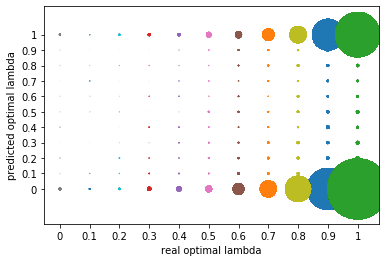

In [138]:
plot_real_predicted_best_lambda(df, rank_type1= "random_all", rank_type2="random",size_constant=0.001,
                                show = True, get_only_first = True, get_all = False,
                                savefig = False, figname = None)

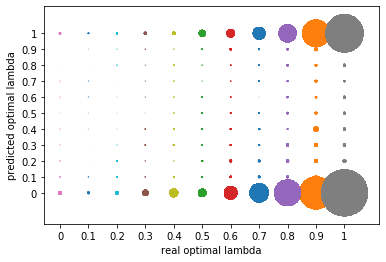

In [139]:
plot_real_predicted_best_lambda(df, rank_type1= "pop_all", rank_type2="pop",size_constant=0.001,
                                show = True, get_only_first = True, get_all = False,
                                savefig = False, figname = None)

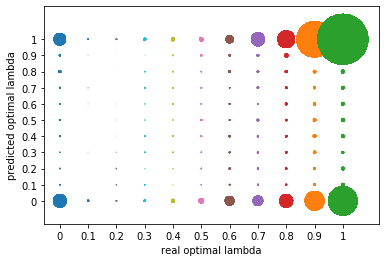

In [135]:
plot_real_predicted_best_lambda(df, rank_type1= "diff_all", rank_type2="diff",size_constant=0.001,
                                show = True, get_only_first = True, get_all = False,
                                savefig = False, figname = None)

### Rating

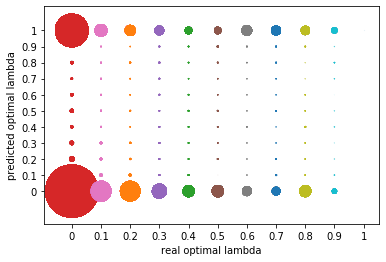

In [143]:
plot_real_predicted_best_lambda(df, rank_type1= "random_all", rank_type2="random",size_constant=0.001,
                                show = True, get_only_first = True, get_all = False,obj = 'rating', 
                                savefig = False, figname = None)

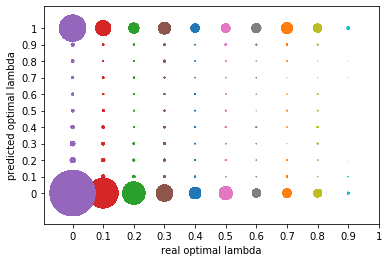

In [144]:
plot_real_predicted_best_lambda(df, rank_type1= "pop_all", rank_type2="pop",size_constant=0.001,
                                show = True, get_only_first = True, get_all = False,obj = 'rating', 
                                savefig = False, figname = None)

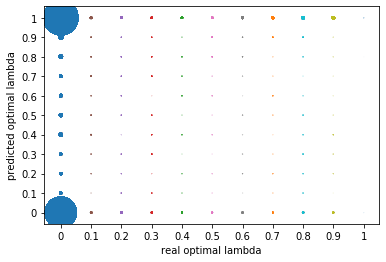

In [146]:
plot_real_predicted_best_lambda(df, rank_type1= "diff_all", rank_type2="diff",size_constant=0.0001,
                                show = True, get_only_first = True, get_all = False,obj = 'rating', 
                                savefig = False, figname = None)

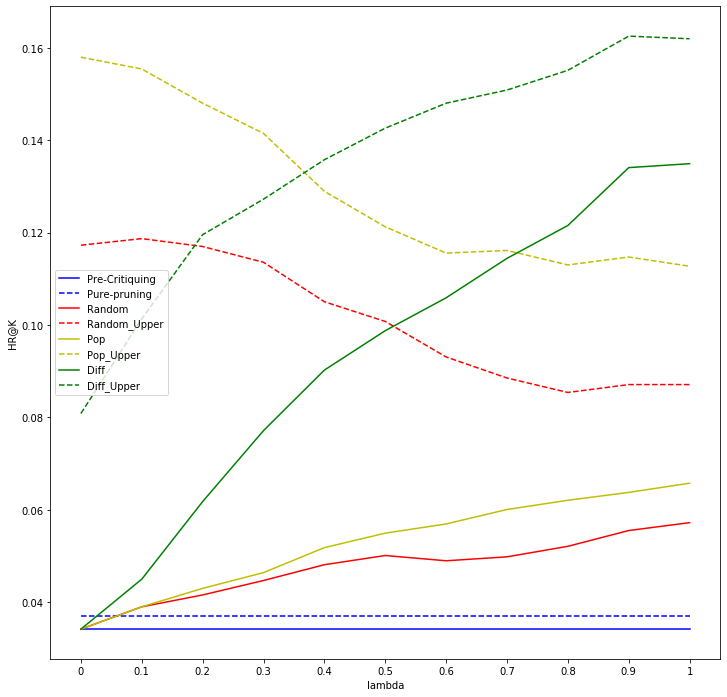

In [140]:
plot_lambda_vs_performance(df, k = 30, show = True, savefig = False)

# Test

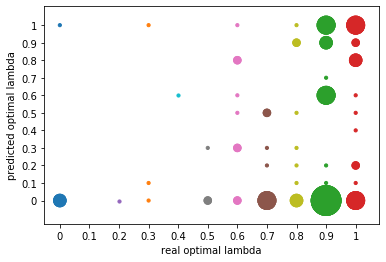

In [124]:
plot_real_predicted_best_lambda(df, rank_type1= "diff_all", rank_type2="diff",size_constant=10,
                                show = True, get_only_first = False, get_all = False,
                                savefig = False, figname = None)

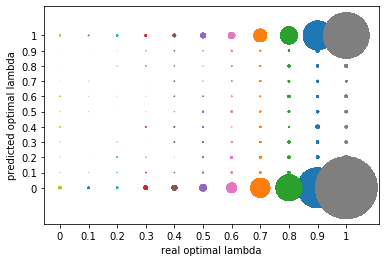

In [117]:
plot_real_predicted_best_lambda(df, rank_type1= "random_all", rank_type2="random",size_constant=0.001,
                                show = True, get_only_first = True, get_all = False,
                                savefig = False, figname = None)

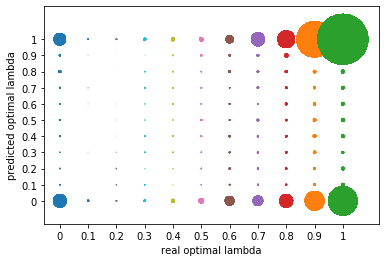

In [118]:
plot_real_predicted_best_lambda(df, rank_type1= "diff_all", rank_type2="diff",size_constant=0.001,
                                show = True, get_only_first = True, get_all = False,
                                savefig = False, figname = None)

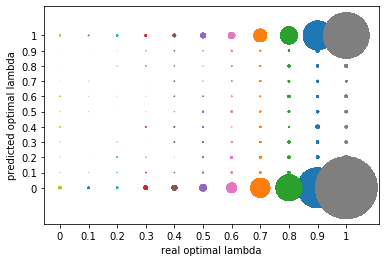

In [54]:
plot_real_predicted_best_lambda(df, rank_type1= "random_all", rank_type2="random",size_constant=0.001,
                                show = True, 
                                savefig = False, figname = None)

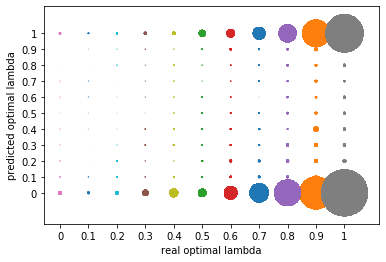

In [55]:
plot_real_predicted_best_lambda(df, rank_type1= "pop_all", rank_type2="pop",size_constant=0.001,
                                show = True, 
                                savefig = False, figname = None)

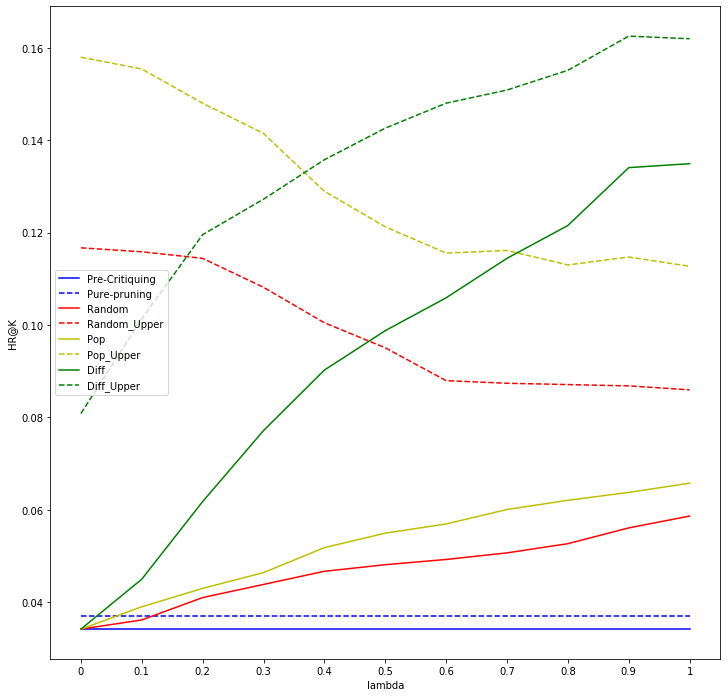

In [53]:
plot_lambda_vs_performance(df, k = 30, show = True, savefig = False)